In [1]:
from functools import partial

import wandb
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
import pandas as pd
import transformers

from custom_datasets import PromptDataset
from gpt_quant_modules import GPTJBlock, GPTJForCausalLM
from gpt_finetuner import FinetunerConfig, GPTJ8bitFineTuner
from finetuning_utils import add_all_adapters, add_attention_adapters

transformers.models.gptj.modeling_gptj.GPTJBlock = GPTJBlock 


==============================WARNING: DEPRECATED!==============================
WARNING! This version of bitsandbytes is deprecated. Please switch to `pip install bitsandbytes` and the new repo: https://github.com/TimDettmers/bitsandbytes
==============================WARNING: DEPRECATED!==============================


The article on [Medium](https://medium.com/@vitaley.grechachin/how-to-train-a-capable-gpt-3-model-at-home-9c5b400ca7f), [Habr]()

# Prepare Data
## Required Data:
 * train and/or validation pandas DataFrame with two columns: prompt, completion
 * prompt + completion length must be less than 2048 tokens
 * For classification metrics completion must be 1 token


In [2]:
# example data

train_df = pd.read_csv('./data/train.csv')
val_df = pd.read_csv('./data/val.csv')

train_df.head()

,label,text
0,offensive,RT @RAYCHIELOVESU: No &#8220;@3rdeyechillin: T...
1,neutral,&#8220;@__Black_Jesus: &#8220;@lil_aerii: Happ...
2,hate,"&#8220;@iamkrause: No need to thank me, killin..."
3,offensive,RT @tr4pb0y: when the pussy so good &amp; u fo...
4,offensive,I talk to these bitches like I really do care.


In [3]:
val_df.head()

,label,text
0,neutral,RT @Black__Elvis: My favorite episode of Frien...
1,hate,RT @TankTopshotta: A real nigga gone teach his...
2,hate,Shoot that nigga an his shorty bitch .
3,hate,@_XoXoKelsey_ hell naw fuck them bitches serve...
4,neutral,@syd_renae okay cool then I'm not the only one...


<AxesSubplot: >

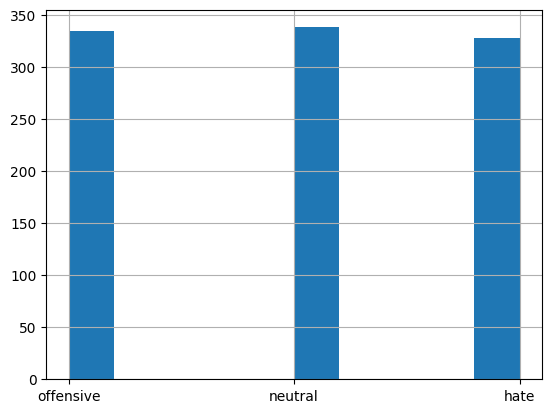

In [4]:
train_df['label'].hist()

In [5]:
# We can create prompt in 2 ways: instruction or raw text
# For instruction propmpt we will use a human understandable textual instruction.
# For raw prompt we will use raw text with special separator between propmpt and completion

def create_instruction_prompt(text, all_labels):
    prompt =  f''' Classify the following messages into one of the following categories: {','.join(all_labels)}

Message: {text}

Category:'''
    return prompt

def create_raw_prompt(text):
    prompt =  f'''{text} /n/n###/n/n'''
    return prompt

# For classification task we need 1 token completion. The completion token must be in model vocabulary. 
# GPT tokenization required completion tokens started with whitespace.

train_df['completion'] = train_df['label'].apply(lambda x: ' '+ x)
val_df['completion'] = val_df['label'].apply(lambda x: ' ' + x)

# instruction based prompt
all_labels = set(train_df['completion'].unique())
train_df['prompt'] = train_df['text'].apply(lambda x: create_instruction_prompt(x, all_labels))
val_df['prompt'] = val_df['text'].apply(lambda x: create_instruction_prompt(x, all_labels))

# # raw text based prompt
# train_df['completion'] = train_df['text'].apply(create_raw_prompt)
# val_df['completion'] = val_df['text'].apply(create_raw_prompt)

train_df.head()

,label,text,completion,prompt
0,offensive,RT @RAYCHIELOVESU: No &#8220;@3rdeyechillin: T...,offensive,Classify the following messages into one of t...
1,neutral,&#8220;@__Black_Jesus: &#8220;@lil_aerii: Happ...,neutral,Classify the following messages into one of t...
2,hate,"&#8220;@iamkrause: No need to thank me, killin...",hate,Classify the following messages into one of t...
3,offensive,RT @tr4pb0y: when the pussy so good &amp; u fo...,offensive,Classify the following messages into one of t...
4,offensive,I talk to these bitches like I really do care.,offensive,Classify the following messages into one of t...


### Prepare training and validation samples

In [6]:
# Create torch Datasets with prepared finetuning samples

# Load tokenizer and add padding token
tokenizer = transformers.AutoTokenizer.from_pretrained("EleutherAI/gpt-j-6B")
tokenizer.pad_token = tokenizer.eos_token

# Define max_prompt_size. Used to pad short prompts and truncate large prompts. Need for batching or fitting VRAM.
# We will take 0.99 quantile tokenized prompt length plus 1 token for completion. 
# Notice that we truncate only propmpt not completion.

max_prompt_size = int(pd.Series(len(tokenizer.tokenize(e)) for e in (train_df['prompt'] + ' ' + train_df['completion'])).quantile(0.99)) + 1


train_dataset = PromptDataset(train_df, tokenizer, max_prompt_len=max_prompt_size)
val_dataset = PromptDataset(val_df, tokenizer, max_prompt_len=max_prompt_size)

# Finetuning of the best model

In [7]:
pl.seed_everything(100)

# logging in wandb
WANDB_PROJECT = "GPT-J_finetune_hatetweets_instruct_final"
wandb.login()
wandb_logger = WandbLogger(project=WANDB_PROJECT)



# Configuration
config = FinetunerConfig(
                        lr=1e-4, 
                        batch_size=2,
                        num_epochs=3, 
                        adapter_dim=2, 
                        classification=True)


# Choose a way to finetune

# Adapters for all linear layers includding embedding
model_post_init_func=partial(add_all_adapters, adapter_dim=config.adapter_dim)

# # Adapters for attention layers
# model_post_init_func=partial(add_attention_adapters, adapter_dim=config.adapter_dim)

# # No adapters, only train model linearnorm
# model_post_init_func=None



finetuner = GPTJ8bitFineTuner(
                                model_name="hivemind/gpt-j-6B-8bit", 
                                model_post_init_func=model_post_init_func, 
                                fine_tuning_config=config, 
                                train_dataset=train_dataset,
                                val_dataset=val_dataset)


trainer = pl.Trainer(   logger=wandb_logger,    
                        log_every_n_steps=1,  
                        gpus=-1,              
                        max_epochs=config.num_epochs,
                        deterministic=True,
                        enable_checkpointing=False,
                    )

trainer.fit(finetuner)
wandb.finish()

Global seed set to 100
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: vetka925. Use `wandb login --relogin` to force relogin


k_proj Linear(in_features=4096, out_features=4096, bias=False)
v_proj Linear(in_features=4096, out_features=4096, bias=False)
q_proj Linear(in_features=4096, out_features=4096, bias=False)
out_proj Linear(in_features=4096, out_features=4096, bias=False)
fc_in Linear(in_features=4096, out_features=16384, bias=True)
fc_out Linear(in_features=16384, out_features=4096, bias=True)
k_proj Linear(in_features=4096, out_features=4096, bias=False)
v_proj Linear(in_features=4096, out_features=4096, bias=False)
q_proj Linear(in_features=4096, out_features=4096, bias=False)
out_proj Linear(in_features=4096, out_features=4096, bias=False)
fc_in Linear(in_features=4096, out_features=16384, bias=True)
fc_out Linear(in_features=16384, out_features=4096, bias=True)
k_proj Linear(in_features=4096, out_features=4096, bias=False)
v_proj Linear(in_features=4096, out_features=4096, bias=False)
q_proj Linear(in_features=4096, out_features=4096, bias=False)
out_proj Linear(in_features=4096, out_features=4096, 

/home/vetka/Projects/torch_jupyter/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:467: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type            | Params
------------------------------------------
0 | model | GPTJForCausalLM | 5.2 M 
------------------------------------------
5.2 M     Trainable params
0         Non-trainable params
5.2 M     Total params
20.833    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/vetka/Projects/torch_jupyter/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:488: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
/home/vetka/Projects/torch_jupyter/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/vetka/Projects/torch_jupyter/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value o

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅█████████████
train_loss,▄▅▃▄▂▂▁▁▁▃▁▁▁▅▁▆▁▁▁▂▁▂▅▁█▁▁▁▃▁▁▃▁▁▄▁▂▁▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_epoch_accuracy,▁▆█
val_epoch_loss,█▁▅
val_loss,█▁▅
epoch,2
train_loss,0.96328
trainer/global_step,1499
val_epoch_accuracy,0.84
val_epoch_loss,0.58263


# Fine-tune report

[WanDB Report](https://api.wandb.ai/links/vetka925/8acj071n)

# Check model generations

In [84]:
# Get trained model
model = finetuner.model.to('cuda')
model.eval()

GPTJForCausalLM(
  (transformer): GPTJModel(
    (wte): FrozenBNBEmbedding(50400, 4096)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0): GPTJBlock(
        (ln_1): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
        (attn): GPTJAttention(
          (attn_dropout): Dropout(p=0.0, inplace=False)
          (resid_dropout): Dropout(p=0.0, inplace=False)
          (k_proj): FrozenBNBLinear(4096, 4096)
          (v_proj): FrozenBNBLinear(4096, 4096)
          (q_proj): FrozenBNBLinear(4096, 4096)
          (out_proj): FrozenBNBLinear(4096, 4096)
        )
        (mlp): GPTJMLP(
          (fc_in): FrozenBNBLinear(4096, 16384)
          (fc_out): FrozenBNBLinear(16384, 4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
      (1): GPTJBlock(
        (ln_1): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
        (attn): GPTJAttention(
          (attn_dropout): Dropout(p=0.0, inplace=False)
 

In [105]:
# Test sample
prompt = '''Classify the following messages into one of the following categories: hate, neutral, offensive

Message: This is the great weather

Category:'''

sample = tokenizer(prompt, return_tensors='pt')
sample = {k: v.to('cuda') for k, v in sample.items()}

In [106]:
# Generate 1 token after prompt
gen_tokens = model.generate(**sample, 
               temperature=0.2, 
               do_sample=True, 
               max_length=(sample['input_ids'].shape[-1]) + 1)
print(tokenizer.decode(gen_tokens[0]))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Classify the following messages into one of the following categories: hate, neutral, offensive

Message: This is the great weather

Category: neutral


### Side effects
The instruction based finetuning has intresting effects.  
The model has trained its attention and now it can be used for classification of unseen labels.

In [107]:
# Let's try to detect bbc news topic

prompt = '''Classify the following messages into one of the following categories: Politics, Sports, Business, Space, Tech, Social

Message: Prime minister said no agreement had yet been made between the UK and the European Union.

Category:'''

sample = tokenizer(prompt, return_tensors='pt')
sample = {k: v.to('cuda') for k, v in sample.items()}

gen_tokens = model.generate(**sample, 
               temperature=0.2, 
               do_sample=True, 
               max_length=(sample['input_ids'].shape[-1]) + 1)
print(tokenizer.decode(gen_tokens[0]))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Classify the following messages into one of the following categories: Politics, Sports, Business, Space, Tech, Social

Message: Prime minister said no agreement had yet been made between the UK and the European Union.

Category: Politics


In [108]:
# Let's try to detect bbc news topic

prompt = '''Classify the following messages into one of the following categories: Politics, Sports, Business, Space, Tech, Social

Message: Netflix cuts prices for subscribers in more than 30 countries

Category:'''

sample = tokenizer(prompt, return_tensors='pt')
sample = {k: v.to('cuda') for k, v in sample.items()}

gen_tokens = model.generate(**sample, 
               temperature=0.2,
               do_sample=False, 
               max_length=(sample['input_ids'].shape[-1]) + 1)
print(tokenizer.decode(gen_tokens[0]))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Classify the following messages into one of the following categories: Politics, Sports, Business, Space, Tech, Social

Message: Netflix cuts prices for subscribers in more than 30 countries

Category: Business


In [109]:
# Let's try to detect bbc news topic

prompt = '''Classify the following messages into one of the following categories: Politics, Sports, Business, Space, Tech, Social

Message: Real Madrid's title hopes suffered a further setback after being held by 10-man rivals Atletico Madrid at the Bernabeu.

Category:'''

sample = tokenizer(prompt, return_tensors='pt')
sample = {k: v.to('cuda') for k, v in sample.items()}

gen_tokens = model.generate(**sample, 
               temperature=0.1,
               do_sample=False, 
               max_length=(sample['input_ids'].shape[-1]) + 1)
print(tokenizer.decode(gen_tokens[0]))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Classify the following messages into one of the following categories: Politics, Sports, Business, Space, Tech, Social

Message: Real Madrid's title hopes suffered a further setback after being held by 10-man rivals Atletico Madrid at the Bernabeu.

Category: Sports


# Conclusion

Best model with adapters for all layers

https://api.wandb.ai/links/vetka925/k8lpj3cn